In [96]:
import numpy as np 
import pandas as pd
from collections import Counter
import json
import re
import seaborn as sns
from datetime import datetime
from pandas import Series
import matplotlib.pyplot as plt

from itertools import combinations
from scipy.stats import ttest_ind

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_selection import f_classif, mutual_info_classif

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
from sklearn.metrics import auc, roc_auc_score, roc_curve
import warnings 
warnings.simplefilter('ignore')

import scipy.sparse as sparse
from sklearn import preprocessing
from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
import sklearn
from sklearn.model_selection import train_test_split

import scipy.sparse as sparse

import nmslib

In [99]:
def roc_auc_curve(y_true, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    plt.figure()
    plt.plot([0, 1], label='Случайный классификатор', linestyle='--')
    plt.plot(fpr, tpr, label = 'LightFM')
    plt.title('ROC AUC = %0.3f' % roc_auc_score(y_true, y_pred_prob))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()
    
def IQR(column):
    perc_25 = df[column].quantile(0.25, interpolation="midpoint")
    perc_75 = df[column].quantile(0.75, interpolation="midpoint")
    IQR = perc_75 - perc_25
    min_out = perc_25 - 1.5 * IQR
    max_out = perc_75 + 1.5 * IQR
    print('Всего выбросов: {} '.format(
        df[df[column] > max_out][column].count()+df[df[column] < min_out][column].count()))
    print('Верхняя граница выбросов:',max_out)
    
def get_stat_dif(column):
    cols = df.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], 'rating'], 
                        df.loc[df.loc[:, column] == comb[1], 'rating']).pvalue \
            <= 0.05/len(combinations_all): 
            print('Найдены статистически значимые различия для колонки', column)
            break
            
def nearest_item_nms(itemid, index, n=10):
    nn = index.knnQuery(item_embeddings[itemid], k=n)
    return nn

In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/sample_submission.csv')

In [4]:
train.head(2)

,overall,verified,reviewTime,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,userid,itemid,rating
0,5.0,True,"10 4, 2016",B01CPNIEQG,Heather,These are my FAVORITE spices in my collection....,Must Add to your Spice kitchen!,1475539200,NaN,NaN,NaN,102179,37138,1.0
1,5.0,True,"03 1, 2016",B006F63M8U,Linda Odom,Add A package to my Coffee and it makes a good...,Milk Chocolate Swiis MIss Hot Cocoa Mix,1456790400,NaN,{'Size:': ' 60-0.73 oz Envelopes'},NaN,3625,17322,1.0


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 857895 entries, 0 to 857894
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         857895 non-null  float64
 1   verified        857895 non-null  bool   
 2   reviewTime      857895 non-null  object 
 3   asin            857895 non-null  object 
 4   reviewerName    857719 non-null  object 
 5   reviewText      857616 non-null  object 
 6   summary         857725 non-null  object 
 7   unixReviewTime  857895 non-null  int64  
 8   vote            118740 non-null  object 
 9   style           444406 non-null  object 
 10  image           7142 non-null    object 
 11  userid          857895 non-null  int64  
 12  itemid          857895 non-null  int64  
 13  rating          857895 non-null  float64
dtypes: bool(1), float64(2), int64(3), object(8)
memory usage: 85.9+ MB


In [6]:
test.head(2)

,verified,reviewTime,asin,reviewerName,unixReviewTime,vote,style,image,userid,itemid,Id
0,True,"10 1, 2016",B001E5E3X0,Rudys Mom,1475280000,NaN,NaN,NaN,68877,7506,0
1,True,"06 29, 2014",B005BYXX5E,pharg,1404000000,2,NaN,NaN,50442,15530,1


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285965 entries, 0 to 285964
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   verified        285965 non-null  bool  
 1   reviewTime      285965 non-null  object
 2   asin            285965 non-null  object
 3   reviewerName    285918 non-null  object
 4   unixReviewTime  285965 non-null  int64 
 5   vote            39462 non-null   object
 6   style           147680 non-null  object
 7   image           2368 non-null    object
 8   userid          285965 non-null  int64 
 9   itemid          285965 non-null  int64 
 10  Id              285965 non-null  int64 
dtypes: bool(1), int64(4), object(6)
memory usage: 22.1+ MB


In [8]:
submission.head(2)

,Id,rating
0,0,0.282813
1,1,0.629758


In [9]:
with open('data/meta_Grocery_and_Gourmet_Food.json') as f:
    meta_list = []
    for line in f.readlines():
        meta_list.append(json.loads(line))
        
meta = pd.DataFrame(meta_list)

In [10]:
meta.head(2)

,category,description,title,brand,rank,also_view,main_cat,price,asin,also_buy,image,date,feature,details,similar_item,tech1,fit
0,"[Grocery & Gourmet Food, Dairy, Cheese & Eggs,...","[BEEMSTER GOUDA CHEESE AGED 18/24 MONTHS, Stat...",Beemster Gouda - Aged 18/24 Months - App. 1.5 Lbs,Ariola Imports,"165,181inGroceryGourmetFood(","[B0000D9MYM, B0000D9MYL, B00ADHIGBA, B00H9OX59...",Grocery,$41.91,0681727810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[Grocery & Gourmet Food, Cooking & Baking, Sug...","[Shipped from UK, please allow 10 to 21 busine...",Trim Healthy Mama Xylitol,NaN,"315,867inGroceryGourmetFood(",NaN,Grocery,NaN,0853347867,"[B01898YHXK, B01BCM6LAC, B00Q4OL47O, B00Q4OL5Q...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287209 entries, 0 to 287208
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   category      287209 non-null  object
 1   description   251802 non-null  object
 2   title         287205 non-null  object
 3   brand         275787 non-null  object
 4   rank          275494 non-null  object
 5   also_view     121012 non-null  object
 6   main_cat      285716 non-null  object
 7   price         132136 non-null  object
 8   asin          287209 non-null  object
 9   also_buy      83332 non-null   object
 10  image         150214 non-null  object
 11  date          9663 non-null    object
 12  feature       16374 non-null   object
 13  details       273323 non-null  object
 14  similar_item  256 non-null     object
 15  tech1         744 non-null     object
 16  fit           4 non-null       object
dtypes: object(17)
memory usage: 37.3+ MB


In [12]:
# удалим идентичные записи
train.drop_duplicates(inplace = True)
train_new = pd.merge(train, meta, on='asin')

In [13]:
train_new.head(2)

,overall,verified,reviewTime,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,...,main_cat,price,also_buy,image_y,date,feature,details,similar_item,tech1,fit
0,5.0,True,"10 4, 2016",B01CPNIEQG,Heather,These are my FAVORITE spices in my collection....,Must Add to your Spice kitchen!,1475539200,NaN,NaN,...,Grocery,$9.95,"[B01DGZ2B48, B01EZ489AO, B01DH795LM, B01EYW2LC...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN
1,5.0,False,"03 31, 2017",B01CPNIEQG,Tina McClain,Love this seasoning on chicken! The flavor is ...,Love all their seasoning!!,1490918400,NaN,NaN,...,Grocery,$9.95,"[B01DGZ2B48, B01EZ489AO, B01DH795LM, B01EYW2LC...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN


In [14]:
train_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 847593 entries, 0 to 847592
Data columns (total 30 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         847593 non-null  float64
 1   verified        847593 non-null  bool   
 2   reviewTime      847593 non-null  object 
 3   asin            847593 non-null  object 
 4   reviewerName    847425 non-null  object 
 5   reviewText      847315 non-null  object 
 6   summary         847426 non-null  object 
 7   unixReviewTime  847593 non-null  int64  
 8   vote            118861 non-null  object 
 9   style           440351 non-null  object 
 10  image_x         7138 non-null    object 
 11  userid          847593 non-null  int64  
 12  itemid          847593 non-null  int64  
 13  rating          847593 non-null  float64
 14  category        847593 non-null  object 
 15  description     776098 non-null  object 
 16  title           847593 non-null  object 
 17  brand     

In [15]:
train_new.isnull().sum()

overall                0
verified               0
reviewTime             0
asin                   0
reviewerName         168
reviewText           278
summary              167
unixReviewTime         0
vote              728732
style             407242
image_x           840455
userid                 0
itemid                 0
rating                 0
category               0
description        71495
title                  0
brand               6104
rank               34598
also_view         384222
main_cat             955
price             258621
also_buy          120735
image_y            92239
date              835506
feature           704859
details            14608
similar_item      846455
tech1             843221
fit               847593
dtype: int64

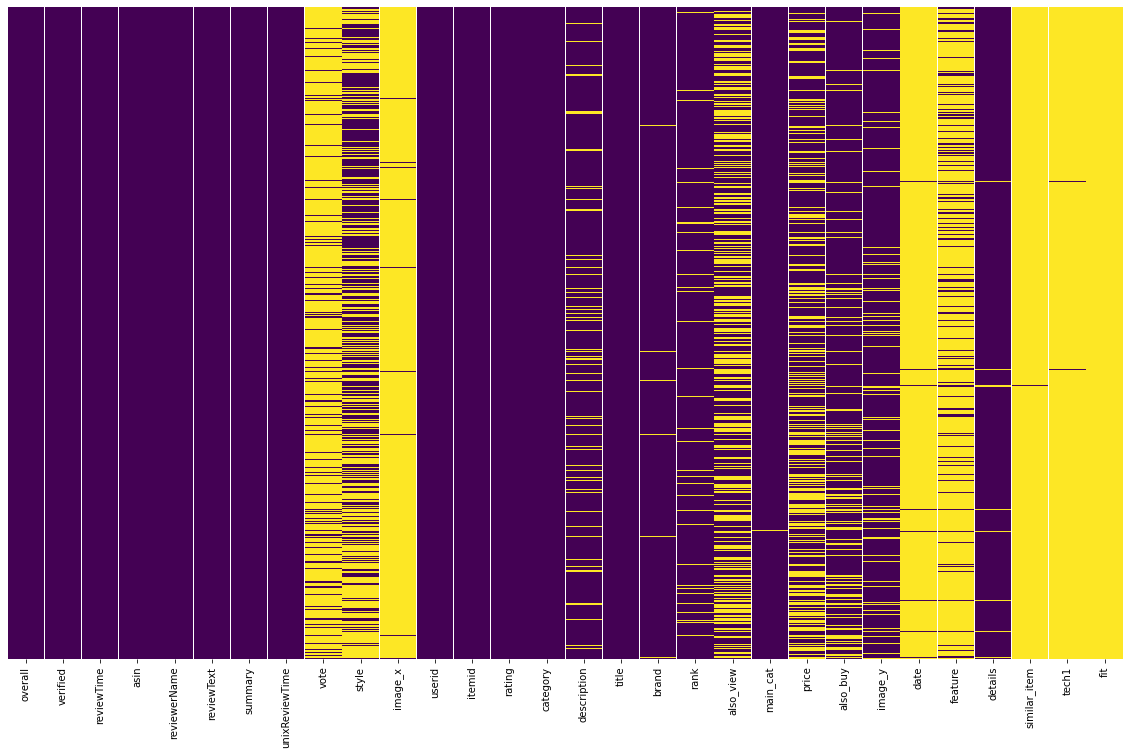

In [16]:
fig, ax = plt.subplots(figsize=(20,12))
sns_heatmap = sns.heatmap(train_new.isnull(), yticklabels=False, cbar=False, cmap='viridis')

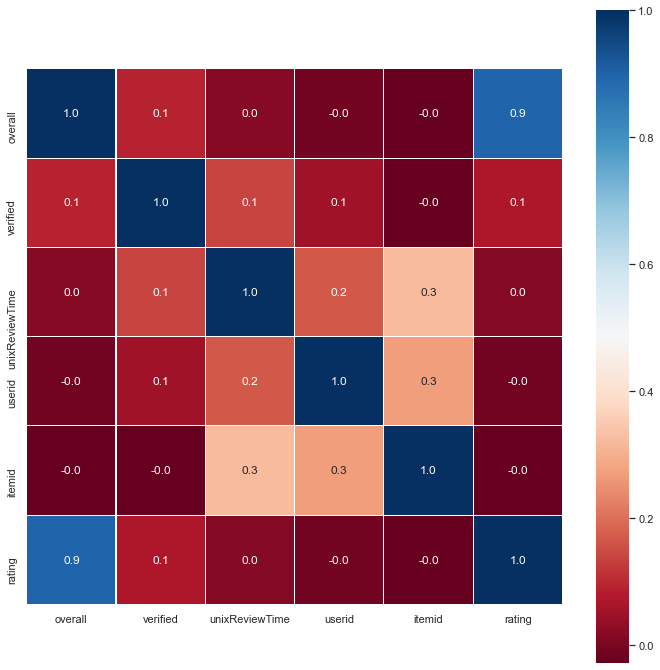

In [17]:
sns.set(font_scale=1)
plt.subplots(figsize=(12, 12))
sns.heatmap(train_new.corr(), square=True,
              annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu")

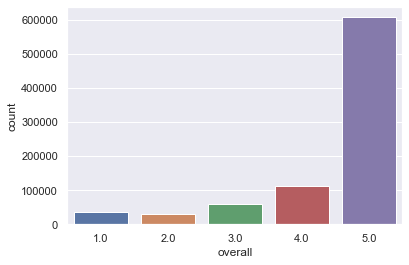

In [18]:
sns.countplot(x="overall", data=train_new)

In [19]:
df = train_new.copy()

In [20]:
num_cols = []
bin_cols = []
cat_cols = []

In [21]:
train_new['category']

0         [Grocery & Gourmet Food, Herbs, Spices & Seaso...
1         [Grocery & Gourmet Food, Herbs, Spices & Seaso...
2         [Grocery & Gourmet Food, Herbs, Spices & Seaso...
3         [Grocery & Gourmet Food, Herbs, Spices & Seaso...
4         [Grocery & Gourmet Food, Herbs, Spices & Seaso...
                                ...                        
847588    [Grocery & Gourmet Food, Candy & Chocolate, Ca...
847589    [Grocery & Gourmet Food, Jams, Jellies & Sweet...
847590    [Grocery & Gourmet Food, Beverages, Coffee, Te...
847591    [Grocery & Gourmet Food, Beverages, Coffee, Te...
847592    [Grocery & Gourmet Food, Canned, Jarred & Pack...
Name: category, Length: 847593, dtype: object

In [22]:
train_new['brand'].value_counts()

KIND                             22506
Bob's Red Mill                   13061
Twinings                         11182
Planters                         10384
Frontier                          6926
                                 ...  
EASTSHORE                            1
Caffe Vita                           1
Factory Card and Party Outlet        1
Drumstick                            1
Drink Chia                           1
Name: brand, Length: 8866, dtype: int64

In [23]:
train_new['also_view']

0         [B00AJRKRJS, B01NALHAY9, B01DGZ2B48, B01EZ489A...
1         [B00AJRKRJS, B01NALHAY9, B01DGZ2B48, B01EZ489A...
2         [B00AJRKRJS, B01NALHAY9, B01DGZ2B48, B01EZ489A...
3         [B00AJRKRJS, B01NALHAY9, B01DGZ2B48, B01EZ489A...
4         [B00AJRKRJS, B01NALHAY9, B01DGZ2B48, B01EZ489A...
                                ...                        
847588    [B004RASYSE, B0007KLGC4, B004R34A48, B004ROS57...
847589    [B073SHX9X9, B073SHFN7C, B06WWRK7VT, B079KKM9B...
847590                                                  NaN
847591                                                  NaN
847592                                                  NaN
Name: also_view, Length: 847593, dtype: object

In [24]:
train_new['main_cat'].value_counts()

Grocery                      802613
Health & Personal Care        31705
Amazon Home                    7383
All Beauty                     1522
Sports & Outdoors              1322
Industrial & Scientific         902
Office Products                 631
Toys & Games                    304
Pet Supplies                    125
Tools & Home Improvement         53
Baby                             34
Arts, Crafts & Sewing            19
Home Audio & Theater              9
Camera & Photo                    8
Software                          3
Musical Instruments               3
Cell Phones & Accessories         2
Name: main_cat, dtype: int64

In [25]:
df = df.drop(['reviewTime', 'asin', 'reviewerName', 'reviewText',
              'summary', 'unixReviewTime', 'style', 'image_x', 'category', 
              'description', 'title', 'brand', 'rank', 'date', 
              'feature', 'details', 'similar_item', 'tech1', 'fit'], axis=1)

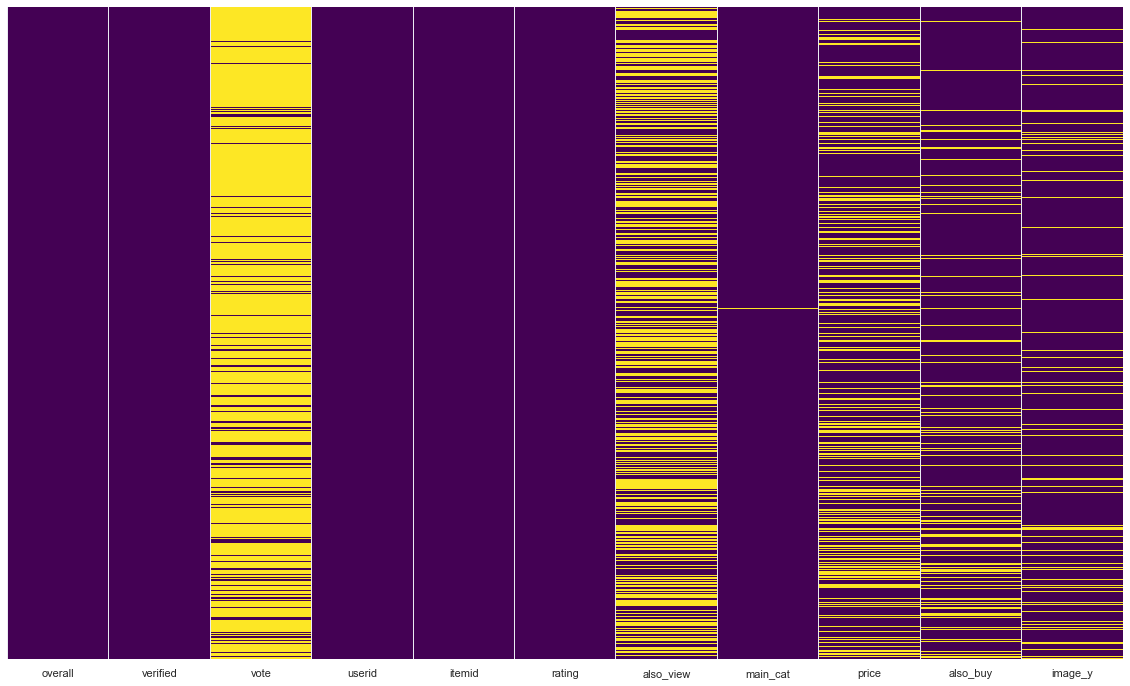

In [26]:
fig, ax = plt.subplots(figsize=(20,12))
sns_heatmap = sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [27]:
df['overall']=df['overall'].astype('int32')
cat_cols.append('overall')

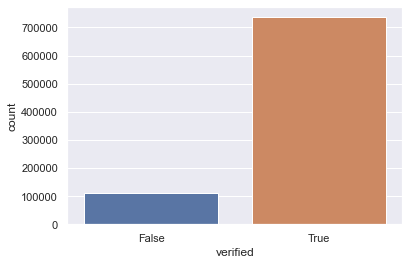

In [28]:
sns.countplot(x = 'verified', data = df)

In [29]:
df['verified'] = df['verified'].map(lambda x: 1 if x == True else 0).astype('int')
bin_cols.append('verified')

In [30]:
df.vote.value_counts()

2.0      30774
3.0      15336
2        13786
4.0       8893
3         6969
         ...  
122.0        1
414.0        1
120.0        1
425.0        1
128          1
Name: vote, Length: 477, dtype: int64

In [31]:
df['vote'] = df['vote'].astype('str')
df['vote'] = df['vote'].apply(lambda x: x.replace(',', ''))
df['vote'] = df['vote'].apply(lambda x: x.replace('nan', '0'))
df.vote = df.vote.fillna(0)
df['vote'] = df['vote'].astype('float')
df['vote'] = df['vote'].astype('int32')

In [32]:
df.vote.value_counts()

0      728732
2       44560
3       22305
4       12872
5        8275
        ...  
594         1
218         1
214         1
211         1
507         1
Name: vote, Length: 312, dtype: int64

In [33]:
df["vote"] = df["vote"].apply(lambda x: 'low' if x == 0 else
    'high' if x > 50 else 'middle')

In [34]:
df.userid.value_counts()

842      427
17987    317
355      302
2024     296
2809     279
        ... 
66068      1
71046      1
90602      1
37414      1
77032      1
Name: userid, Length: 127448, dtype: int64

In [35]:
num_cols.append('userid')

In [36]:
df.rating.value_counts()

1.0    719392
0.0    128201
Name: rating, dtype: int64

In [37]:
df['rating']=df['rating'].astype('int32')
bin_cols.append('rating')

In [38]:
df.main_cat.value_counts()

Grocery                      802613
Health & Personal Care        31705
Amazon Home                    7383
All Beauty                     1522
Sports & Outdoors              1322
Industrial & Scientific         902
Office Products                 631
Toys & Games                    304
Pet Supplies                    125
Tools & Home Improvement         53
Baby                             34
Arts, Crafts & Sewing            19
Home Audio & Theater              9
Camera & Photo                    8
Software                          3
Musical Instruments               3
Cell Phones & Accessories         2
Name: main_cat, dtype: int64

In [39]:
df.main_cat = df.main_cat.fillna('others')

In [40]:
df.price.value_counts()

$14.99              14241
$13.67              10660
$19.99               9043
$14.79               5632
$15.53               5561
                    ...  
$2.08                   2
$6.93                   1
$35.16                  1
$19.99 - $295.00        1
$44.14                  1
Name: price, Length: 4601, dtype: int64

In [41]:
df['price'] = df['price'].astype('str')
df['price'] = df['price'].apply(lambda x: re.sub('\D', '', x))
df['price'] = df['price'].apply(lambda x: 0 if x == '' else x)
df['price'] = df['price'].astype('float')
df['price'] = df['price'].apply(lambda x: x/100)

In [42]:
IQR('price')

Всего выбросов: 18599 
Верхняя граница выбросов: 53.75


In [43]:
df['price'] = df['price'].apply(lambda x: 0 if x > 100 else x)

In [44]:
df['price'] = df['price'].astype('int')

In [45]:
a = df['price'].mean()
df['price'] = df['price'].apply(lambda x: a if x == 0 else x)

In [46]:
df.price.value_counts()

13.455983    264415
14.000000     41302
13.000000     33267
9.000000      26349
11.000000     23830
              ...  
88.000000        20
90.000000        19
81.000000        16
97.000000        12
91.000000         7
Name: price, Length: 100, dtype: int64

In [47]:
df["price"] = df["price"].apply(lambda x: 'low' if x < 10 else
    'high' if x > 20 else 'middle')

In [48]:
df.also_view

0         [B00AJRKRJS, B01NALHAY9, B01DGZ2B48, B01EZ489A...
1         [B00AJRKRJS, B01NALHAY9, B01DGZ2B48, B01EZ489A...
2         [B00AJRKRJS, B01NALHAY9, B01DGZ2B48, B01EZ489A...
3         [B00AJRKRJS, B01NALHAY9, B01DGZ2B48, B01EZ489A...
4         [B00AJRKRJS, B01NALHAY9, B01DGZ2B48, B01EZ489A...
                                ...                        
847588    [B004RASYSE, B0007KLGC4, B004R34A48, B004ROS57...
847589    [B073SHX9X9, B073SHFN7C, B06WWRK7VT, B079KKM9B...
847590                                                  NaN
847591                                                  NaN
847592                                                  NaN
Name: also_view, Length: 847593, dtype: object

In [49]:
df.also_buy

0         [B01DGZ2B48, B01EZ489AO, B01DH795LM, B01EYW2LC...
1         [B01DGZ2B48, B01EZ489AO, B01DH795LM, B01EYW2LC...
2         [B01DGZ2B48, B01EZ489AO, B01DH795LM, B01EYW2LC...
3         [B01DGZ2B48, B01EZ489AO, B01DH795LM, B01EYW2LC...
4         [B01DGZ2B48, B01EZ489AO, B01DH795LM, B01EYW2LC...
                                ...                        
847588                                                  NaN
847589    [B073SHX9X9, B01H68M39Y, B00GU19JRI, B0799CH1Z...
847590    [B001O4EKJI, B002H1PS34, B00WRGGB7G, B005DOQME...
847591                                                  NaN
847592    [B019YHTJ2E, B000KHMWQS, B00MK5E2Q6, B00F9XCEM...
Name: also_buy, Length: 847593, dtype: object

In [50]:
# coздадим пару features - количество продуктов и количество просмотров
df['also_buy_numb'] = df['also_buy'].str.len()
df['also_view_numb'] = df['also_view'].str.len()
df['also_buy_numb'] = df['also_buy_numb'].fillna(0)
df['also_view_numb'] = df['also_view_numb'].fillna(0)
df['also_buy_numb'] = df['also_buy_numb'].astype(int)
df['also_view_numb'] = df['also_view_numb'].astype(int)

In [51]:
num_cols.append('also_buy_numb')
num_cols.append('also_view_numb')

In [52]:
df = df.drop(['also_buy'], axis = 1)
df = df.drop(['also_view'], axis = 1)

In [53]:
df.head(2)

,overall,verified,vote,userid,itemid,rating,main_cat,price,image_y,also_buy_numb,also_view_numb
0,5,1,low,102179,37138,1,Grocery,low,[https://images-na.ssl-images-amazon.com/image...,85,54
1,5,0,low,117314,37138,1,Grocery,low,[https://images-na.ssl-images-amazon.com/image...,85,54


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 847593 entries, 0 to 847592
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   overall         847593 non-null  int32 
 1   verified        847593 non-null  int32 
 2   vote            847593 non-null  object
 3   userid          847593 non-null  int64 
 4   itemid          847593 non-null  int64 
 5   rating          847593 non-null  int32 
 6   main_cat        847593 non-null  object
 7   price           847593 non-null  object
 8   image_y         755354 non-null  object
 9   also_buy_numb   847593 non-null  int32 
 10  also_view_numb  847593 non-null  int32 
dtypes: int32(5), int64(2), object(4)
memory usage: 101.4+ MB


In [55]:
df.image_y

0         [https://images-na.ssl-images-amazon.com/image...
1         [https://images-na.ssl-images-amazon.com/image...
2         [https://images-na.ssl-images-amazon.com/image...
3         [https://images-na.ssl-images-amazon.com/image...
4         [https://images-na.ssl-images-amazon.com/image...
                                ...                        
847588    [https://images-na.ssl-images-amazon.com/image...
847589    [https://images-na.ssl-images-amazon.com/image...
847590    [https://images-na.ssl-images-amazon.com/image...
847591                                                  NaN
847592                                                  NaN
Name: image_y, Length: 847593, dtype: object

In [56]:
df['image_y'] = df['image_y'].fillna(0)
df['image']= df['image_y'].apply(lambda x: 0 if x==0 else 1)
bin_cols.append('image')

In [57]:
df = df.drop(['image_y'], axis=1)

In [58]:
df.head(3)

,overall,verified,vote,userid,itemid,rating,main_cat,price,also_buy_numb,also_view_numb,image
0,5,1,low,102179,37138,1,Grocery,low,85,54,1
1,5,0,low,117314,37138,1,Grocery,low,85,54,1
2,3,1,middle,119505,37138,0,Grocery,low,85,54,1


In [59]:
# преобразование с помощью LabelEncoder()
label_encoder = LabelEncoder()

In [60]:
mapped = pd.Series(label_encoder.fit_transform(df['vote']))
print(dict(enumerate(label_encoder.classes_)))

{0: 'high', 1: 'low', 2: 'middle'}


In [61]:
df['vote'] = label_encoder.fit_transform(df['vote'])
df.sample(3)

,overall,verified,vote,userid,itemid,rating,main_cat,price,also_buy_numb,also_view_numb,image
537698,5,1,2,25301,18083,1,Grocery,middle,42,0,1
23045,5,1,1,37774,32178,1,Grocery,low,96,0,1
596098,5,1,1,20214,19025,1,Grocery,high,21,0,1


In [62]:
cat_cols.append('vote')

In [63]:
mapped = pd.Series(label_encoder.fit_transform(df['main_cat']))
print(dict(enumerate(label_encoder.classes_)))
df['main_cat'] = label_encoder.fit_transform(df['main_cat'])
cat_cols.append('main_cat')

{0: 'All Beauty', 1: 'Amazon Home', 2: 'Arts, Crafts & Sewing', 3: 'Baby', 4: 'Camera & Photo', 5: 'Cell Phones & Accessories', 6: 'Grocery', 7: 'Health & Personal Care', 8: 'Home Audio & Theater', 9: 'Industrial & Scientific', 10: 'Musical Instruments', 11: 'Office Products', 12: 'Pet Supplies', 13: 'Software', 14: 'Sports & Outdoors', 15: 'Tools & Home Improvement', 16: 'Toys & Games', 17: 'others'}


In [64]:
dummies = pd.get_dummies(df['price'], prefix = df['price'].name)
df.head(2)

,overall,verified,vote,userid,itemid,rating,main_cat,price,also_buy_numb,also_view_numb,image
0,5,1,1,102179,37138,1,6,low,85,54,1
1,5,0,1,117314,37138,1,6,low,85,54,1


In [65]:
df = df.drop(df['price'].name, axis=1).join(dummies)
bin_cols.append('price_high')
bin_cols.append('price_middle')
bin_cols.append('price_low')

In [66]:
df.head(3)

,overall,verified,vote,userid,itemid,rating,main_cat,also_buy_numb,also_view_numb,image,price_high,price_low,price_middle
0,5,1,1,102179,37138,1,6,85,54,1,0,1,0
1,5,0,1,117314,37138,1,6,85,54,1,0,1,0
2,3,1,2,119505,37138,0,6,85,54,1,0,1,0


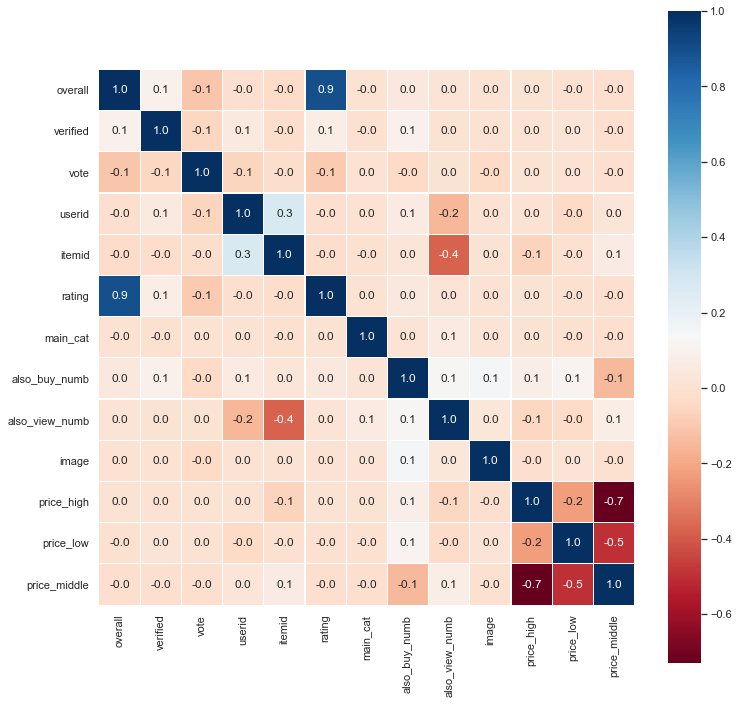

In [67]:
sns.set(font_scale=1)
plt.subplots(figsize=(12, 12))
sns.heatmap(df.corr(), square=True,
              annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu")

In [68]:
df = df.drop(['overall'], axis = 1)

In [69]:
for col in bin_cols:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки verified
Найдены статистически значимые различия для колонки rating
Найдены статистически значимые различия для колонки image
Найдены статистически значимые различия для колонки price_high
Найдены статистически значимые различия для колонки price_middle
Найдены статистически значимые различия для колонки price_low


In [70]:
train_data, test_data = train_test_split(train,random_state=32, shuffle=True)

In [71]:
ratings_coo = sparse.coo_matrix((train_data['rating'].astype(int),
                                 (train_data['userid'],
                                  train_data['itemid'])))
NUM_THREADS = 4 #число потоков
NUM_COMPONENTS = 160 #число параметров вектора 
NUM_EPOCHS = 20 #число эпох обучения
RANDOM_STATE = 32


model = LightFM(learning_rate=0.09, loss='logistic',
                no_components=NUM_COMPONENTS, random_state = RANDOM_STATE)
model = model.fit(ratings_coo, epochs=NUM_EPOCHS, 
                  num_threads=NUM_THREADS)

In [72]:
preds = model.predict(test_data.userid.values,
                      test_data.itemid.values)

In [73]:
sklearn.metrics.roc_auc_score(test_data.rating,preds)

0.7315118251480361

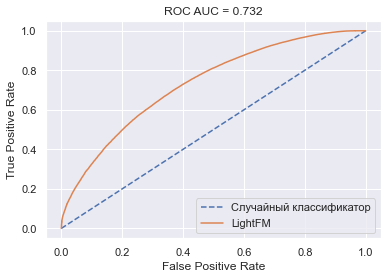

In [74]:
roc_auc_curve(test_data.rating,preds)

In [75]:
normalized_preds = (preds - preds.min())/(preds - preds.min()).max()

In [76]:
preds.min(), preds.max()

(-34.03071, 33.507935)

In [78]:
train_data, test_data = train_test_split(df,random_state=32, shuffle=True)
ratings_coo2 = sparse.coo_matrix((train_data['rating'].astype(int),
                                 (train_data['userid'],
                                  train_data['itemid'])))

model = LightFM(learning_rate=0.1, loss='logistic',
                no_components=NUM_COMPONENTS, random_state = RANDOM_STATE)
model2 = model.fit(ratings_coo2, epochs=NUM_EPOCHS, 
                  num_threads=NUM_THREADS)

In [79]:
preds2 = model2.predict(test_data.userid.values,
                      test_data.itemid.values)

In [80]:
sklearn.metrics.roc_auc_score(test_data.rating,preds2)

0.7419578807987918

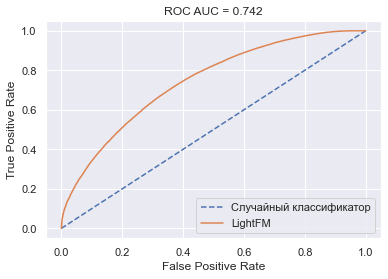

In [81]:
roc_auc_curve(test_data.rating,preds2)

In [82]:
normalized_preds2 = (preds2 - preds2.min())/(preds2 - preds2.min()).max()
preds2.min(), preds2.max()

(-35.75574, 27.413054)

In [84]:
preds_sub = model2.predict(test.userid.values,
                      test.itemid.values)

In [85]:
normalized_preds_sub = (preds_sub - preds_sub.min())/(preds_sub - preds_sub.min()).max()
preds_sub.min(), preds_sub.max()

(-33.06127, 28.156012)

In [89]:
item_features = train_data[['image','main_cat','price_high','price_low','price_middle']]
norm_ifeatures = (item_features - item_features.mean()) / item_features.std()
item_features=(sparse.csr_matrix(norm_ifeatures)).astype(np.float32)

In [90]:
user_features = train_data[['verified','vote','also_buy_numb','also_view_numb']]
norm_ufeatures = (user_features - user_features.mean()) / user_features.std()
user_features = (sparse.csr_matrix(norm_ufeatures)).astype(np.float32)

In [91]:
NUM_THREADS = 4  # число потоков
NUM_COMPONENTS = 160  # число параметров вектора
NUM_EPOCHS = 20  # число эпох обучения
RANDOM_STATE = 32
model = LightFM(learning_rate=0.09, loss='logistic',
                no_components=NUM_COMPONENTS)
model_feat = model.fit(ratings_coo, user_features=user_features, item_features=item_features, epochs=NUM_EPOCHS,
                       num_threads=NUM_THREADS)

In [92]:
userid = np.array(test_data.userid).astype(np.int32)
itemid =np.array(test_data.itemid).astype(np.int32) 

In [93]:
preds0 = model_feat.predict(userid, itemid, item_features=item_features,
                            user_features=user_features,num_threads=NUM_THREADS)

In [94]:
sklearn.metrics.roc_auc_score(test_data.rating,preds0)

0.5007680257473082

In [95]:
item_biases, item_embeddings = model2.get_item_representations()
item_biases.shape, item_embeddings.shape

((41320,), (41320, 160))

In [97]:
#Создаём граф для поиска
nms_idx = nmslib.init(method='hnsw', space='cosinesimil')

In [98]:
nms_idx.addDataPointBatch(item_embeddings)
nms_idx.createIndex(print_progress=True)

In [100]:
mapper = dict(zip(meta['asin'],meta['title']))

In [102]:
train['title'] = train.asin.apply(lambda x: mapper[x])
test['title'] = test.asin.apply(lambda x: mapper[x])
prod_id = train.drop(['verified','reviewTime','reviewerName',
                      'reviewText','summary','vote','style','image'],axis=1)

In [109]:
prod_id[prod_id.title.str.find('Chips')>=0].head(5)

,overall,asin,unixReviewTime,userid,itemid,rating,title
4,5.0,B000R7RN0G,1473811200,74859,4349,1.0,Miss Vickie's Jalapeño Flavored Kettle Cooked ...
12,5.0,B00MBVD5DA,1440115200,116113,29984,1.0,"Indus Organics Dried Coconut Chips/shreds, Raw..."
67,4.0,B004CYJXQW,1409788800,49815,13252,1.0,"Special K Cracker Chips, Sea Salt, 3.48 Ounce ..."
82,4.0,B013IG9KVW,1357776000,46481,34947,1.0,Stacy's Parmesan Garlic & Herb Flavored Pita C...
202,5.0,B00HQDVRU6,1475712000,24352,26993,1.0,"Kettle Brand Potato Chips, Sriracha, 8.5 Ounce..."


In [110]:
# Ищем похожие товары
nbm = nearest_item_nms(67,nms_idx)[0]

In [111]:
prod_id[prod_id.itemid.isin(nbm)]

,overall,asin,unixReviewTime,userid,itemid,rating,title
17292,2.0,B000HDGDDI,1338508800,59657,2589,0.0,"Orville Redenbacher's Kettle Korn Popcorn, Sin..."
48112,5.0,B000LKU3UG,1260230400,35761,3192,1.0,"Real Foods Organic Corn Thins, Sesame Flavor, ..."
75408,5.0,B000Q7UCAK,1475625600,39472,4191,1.0,Montasio Cheese 1 lb
87813,4.0,B01CYI3TLM,1505865600,18077,41250,1.0,"Yoplait, Original Yogurt, Variety Pack (strawb..."
107782,3.0,B00KFL8VYG,1431302400,7265,28902,0.0,"McCormick Grill Mates Special 12 (Marinades,Se..."
118377,5.0,B0000D954D,1354752000,1587,67,1.0,Sans Sucre Cinnamon Sugar Substitute
121200,3.0,B00Z4ZBJCO,1480636800,62787,34211,0.0,Custom Variety Pack Hot Cocoa Single Serve Cup...
127060,5.0,B00KFL8VYG,1422835200,84721,28902,1.0,"McCormick Grill Mates Special 12 (Marinades,Se..."
127347,5.0,B00MCJDWMK,1464307200,116919,40752,1.0,"Ceylon Pure Organic Coconut Flakes, Medium, 8 ..."
136871,5.0,B0000D954D,1513296000,124600,67,1.0,Sans Sucre Cinnamon Sugar Substitute


In [113]:
submission['rating']= normalized_preds_sub
submission

,Id,rating
0,0,0.570940
1,1,0.556893
2,2,0.535917
3,3,0.539933
4,4,0.554013
...,...,...
285960,285960,0.580005
285961,285961,0.470622
285962,285962,0.558512
285963,285963,0.582985


In [114]:
submission.to_csv('submission_log.csv', index=False)